In [1]:
import tensorflow as tf
from tensorflow.contrib.layers import xavier_initializer
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import norm

from sklearn.neighbors import KernelDensity
from matplotlib import pyplot as plt
from matplotlib import animation, rc

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rc('animation', html='html5')

In [2]:
def EDF(X):
    N = len(X)
    Y = [n/float(N) for n in range(N)]
    return(sorted(X), Y)

In [3]:
def CDF(p, minx = -5, maxx = 5, dx = .1):
    X = np.arange(minx,maxx,dx)
    Y = tf.cumsum(p(np.arange(minx,maxx,dx).reshape(-1,1)))*dx
    return(X, Y)

In [4]:
def sq_dists(Z):
    A = tf.reshape(Z, (tf.shape(Z)[0], -1))
    r = tf.reduce_sum(A*A, 1)
    r = tf.reshape(r, [-1, 1])
    sqdists = r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r)
    return sqdists

def med(D):
    m = tf.contrib.distributions.percentile(D, 50)
    return m
    
def kernel(Z, h = -1):
    sqdists = sq_dists(Z)
    if h <= 0:
        medsq = med(sqdists)
        h = medsq / np.log(Z.shape.as_list()[0])
    h = tf.stop_gradient(h)
    ker = tf.exp(-sqdists/h)
    A = tf.tile(tf.expand_dims(Z, 0), (Z.shape.as_list()[0],1,1))
    T = tf.transpose(A, (1,0,2)) - A
    dker_dz = -2*tf.multiply(tf.tile(tf.expand_dims(ker, 2), (1,1,Z.shape.as_list()[1])), T)/h
    return(ker, dker_dz)

def phi_star(Z, p, h = -1):
    ker, dker = kernel(Z, h=h)
    logp = tf.log(p(X))
    dlogp = tf.gradients(logp, X)[0]
    phi_mat = tf.einsum('ij,ik->ijk', ker, dlogp) + dker
    phi_mean = tf.reduce_mean(phi_mat, 0)
    return(phi_mean)

In [5]:
p = lambda z: .5*(1/np.sqrt(2*np.pi*.5))*tf.exp(-tf.square(tf.norm(z-2, axis=1))/(2*.5)) + .5*(1/np.sqrt(2*np.pi*.5))*tf.exp(-tf.square(tf.norm(z+2, axis=1))/(2*.5))

In [179]:
n = 500
X0 = np.random.uniform(-5,5,n).astype('float32').reshape(n,-1)
X = tf.Variable(X0)
sess = tf.Session()

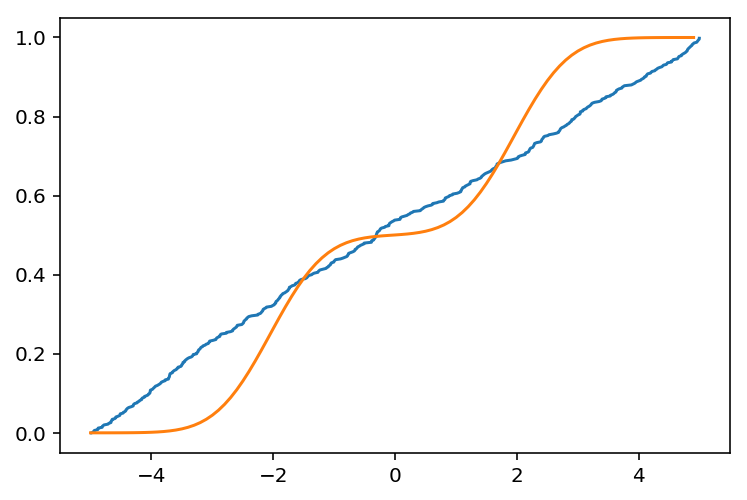

In [180]:
edf = EDF(X0)
plt.plot(edf[0], edf[1])

cdf = CDF(p)
plt.plot(cdf[0], sess.run(cdf[1]))

In [181]:
loss = -tf.reduce_sum(tf.einsum('ij,ij->i', X, tf.stop_gradient(phi_star(X, p))))
solver = tf.train.AdagradOptimizer(learning_rate = 1e-1).minimize(loss, var_list=X)

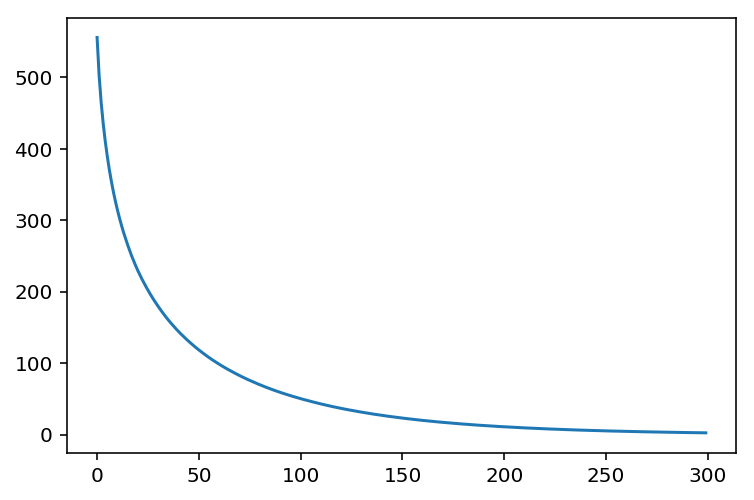

In [182]:
iters = 300

init = tf.global_variables_initializer()
sess = tf.Session()
with sess.as_default():
    sess.run(init)
    
    Xs = []
    losses = []
    for i in range(iters):
        _, loss_curr = sess.run([solver, loss])
        losses.append(loss_curr)
        if i % max(1, iters/100) == 0:
            Xs.append(sess.run(X))
plt.figure()
plt.plot(losses)

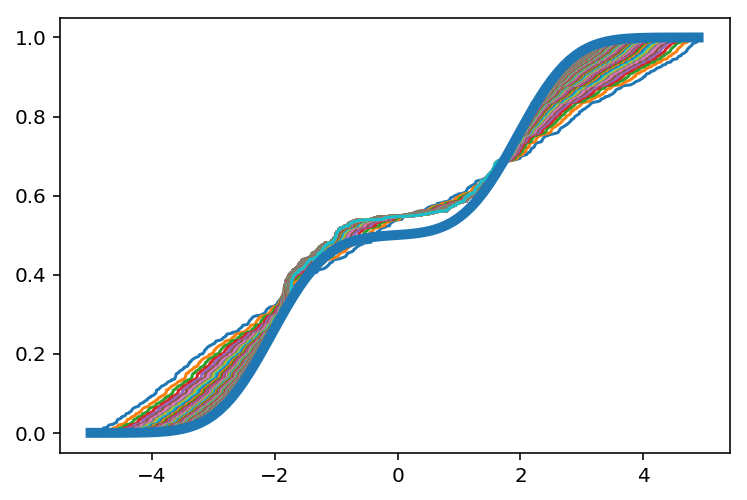

In [183]:
for x in Xs:
    edf = EDF(x)
    plt.plot(edf[0], edf[1])
cdf = CDF(p)
plt.plot(cdf[0], sess.run(cdf[1]), linewidth=5.0)

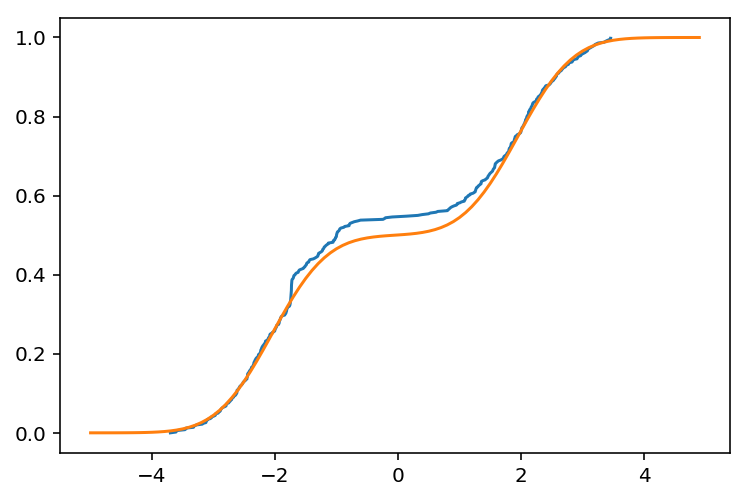

In [184]:
edf = EDF(X.eval(session=sess))
plt.plot(edf[0], edf[1])
cdf = CDF(p)
plt.plot(cdf[0], sess.run(cdf[1]))

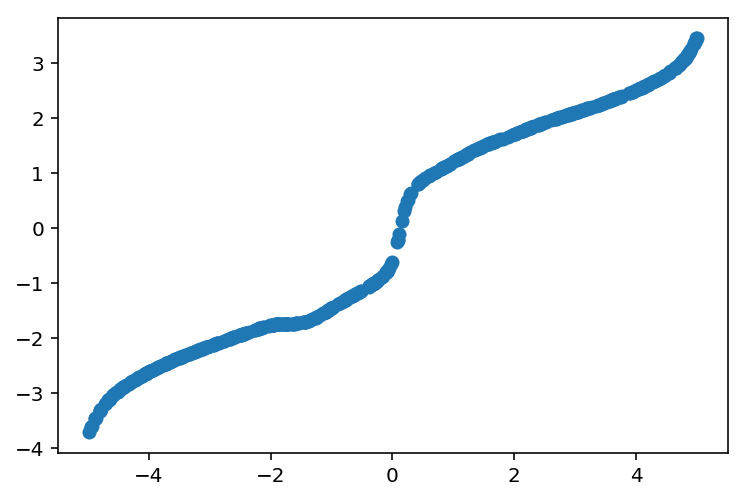

In [185]:
plt.scatter(X0, X.eval(session=sess))

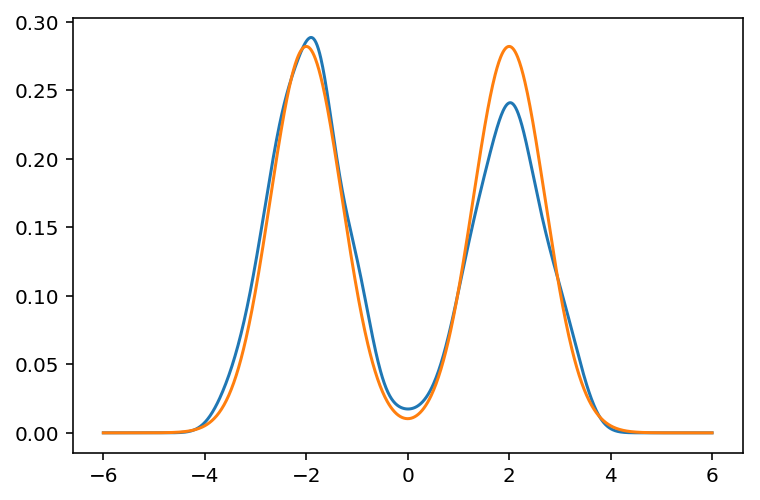

In [186]:
X_plot = np.linspace(-6, 6, 1000)[:, None]
log_dens = KernelDensity(kernel="gaussian", bandwidth = .3).fit(X.eval(session=sess)).score_samples(X_plot)
plt.plot(X_plot, np.exp(log_dens))
plt.plot(X_plot, sess.run(p(X_plot)))

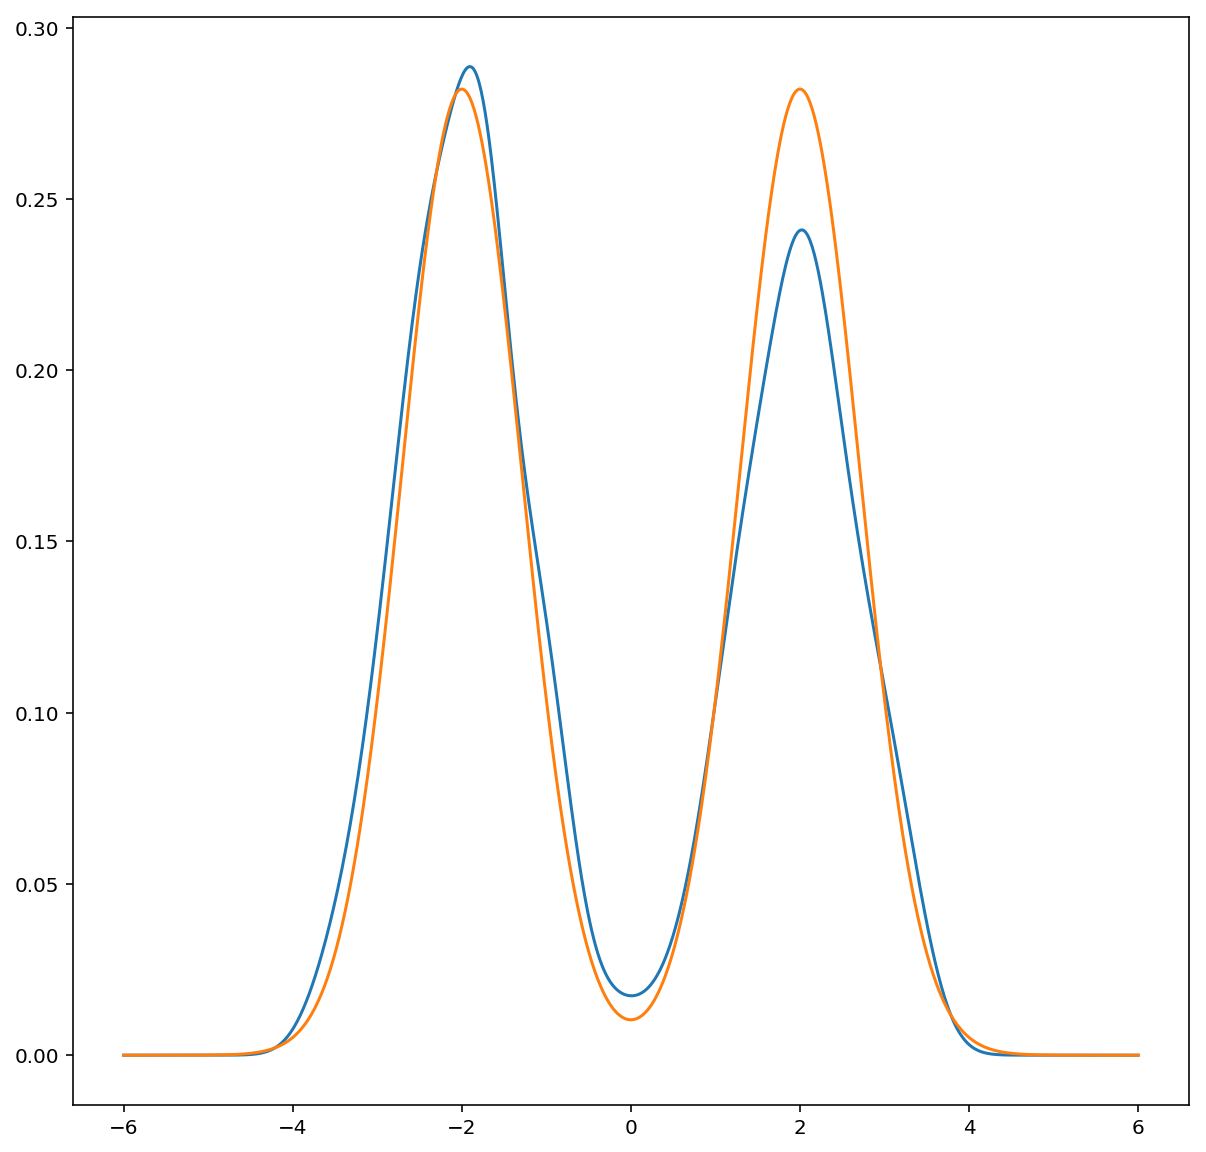

In [187]:
log_dens = KernelDensity(kernel="gaussian", bandwidth = .3).fit(X.eval(session=sess)).score_samples(X_plot)

fig, ax = plt.subplots(figsize=(10,10))
line, = ax.plot(X_plot, np.exp(log_dens))
ax.plot(X_plot, sess.run(p(X_plot)))

# initialization function: plot the background of each frame
# def init():
#     line.set_data(f(t), f(t))
#     return (line,)
# animation function. This is called sequentially
def animate(i):
    log_dens = KernelDensity(kernel="gaussian", bandwidth = .3).fit(Xs[i]).score_samples(X_plot)
    line.set_data(X_plot, np.exp(log_dens))
    return (line,)
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, #init_func=init,
                               frames=len(Xs), interval=5000/float(len(Xs)), blit=True)


rc('animation', html='html5')

anim